# part0: imports

In [4]:
import os, sys, pathlib
from pprint import pprint
import gc
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)



import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import scipy.linalg as linalg

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.ticker import MaxNLocator

import pyaldata as pyal

%matplotlib inline

try:
    nbPath = pathlib.Path.cwd()
    RepoPath = nbPath.parent
    os.chdir(RepoPath)

    from tools import utilityTools as utility
    from tools import dataTools as dt
    import params
    defs = params.monkey_defs
    monkey_defs = defs
    
    set_rc =  params.set_rc_params
    set_rc()
    root = params.root
    reload(defs)
    reload(dt)
    reload(params) 

finally:
    os.chdir(nbPath)

if "__file__" not in dir():
    %run "_dataset-selection.ipynb"

In [5]:
def get_full_monkey_data():
    full_list_MCx = []
    for animal, sessionList in GoodDataList[monkey_defs.areas[2]].items():
        if 'Mr' in animal:
            continue  # to remove MrT
        full_list_MCx.append((animal,sessionList))
    full_list_MCx = [(animal,session) for animal,sessions in full_list_MCx for session in set(sessions)]
    # load the DFs
    allDFs_MCx = []
    for animal, session in full_list_MCx:
        path = root/animal/session
        allDFs_MCx.append(monkey_defs.prep_general(dt.load_pyal_data(path)))

    return full_list_MCx, allDFs_MCx

collecting all the data in a matrix, `AllData`: $sessions \times targets \times  trials \times time \times PCs$

In [10]:
if "__file__" not in dir():
    warnings.filterwarnings("ignore")
    full_list_MCx, allDFs_MCx = get_full_monkey_data()
    
    pairFileList1 = []
    for I, (animal1,session1) in enumerate(full_list_MCx):
        for J, (animal2,session2) in enumerate(full_list_MCx):
            if J<=I or animal1 == animal2: continue  # to repetitions
            if 'Chewie' in animal1 and 'Chewie' in animal2: continue 
            pairFileList1.append((I,J))

    side1df = [allDFs_MCx[i] for i,_ in pairFileList1]
    side2df = [allDFs_MCx[j] for _,j in pairFileList1]

    AllData1 = dt.get_data_array(side1df, monkey_defs.exec_epoch, area=monkey_defs.areas[2], model=monkey_defs.n_components)
    AllData2 = dt.get_data_array(side2df, monkey_defs.exec_epoch, area=monkey_defs.areas[2], model=monkey_defs.n_components)
    _,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)

    warnings.filterwarnings("default")

do the CCA calculation

In [18]:
if "__file__" not in dir():
    CCs=[]
    for sessionData1,sessionData2 in zip(AllData1,AllData2):
        data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,defs.n_components))
        data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,defs.n_components))
        CCs.append(dt.canoncorr(data1, data2))
    CCs = np.array(CCs)

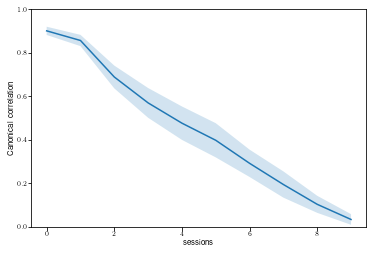

In [25]:
if "__file__" not in dir():
    utility.shaded_errorbar(plt.gca(),CCs.T,)
    plt.ylim([0,1])
    plt.xlabel('sessions')
    plt.ylabel('Canonical correlation')
